# Instance segmentation

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

image.mode: RGB


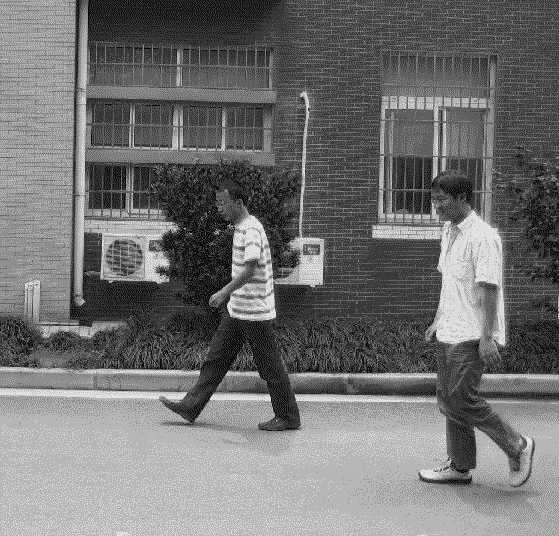

In [4]:
from PIL import Image
image = Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
print('image.mode:',image.mode)
# L模式转换为调色板模式P
image = image.convert('P')
# 获取图片原始的调色板
image_palette = image.getpalette()
# 自定义调色板（灰度图R=G=B）
image.putpalette([i for i in range(0,256) for j in range(3)])
image

mask_np: (536, 559)


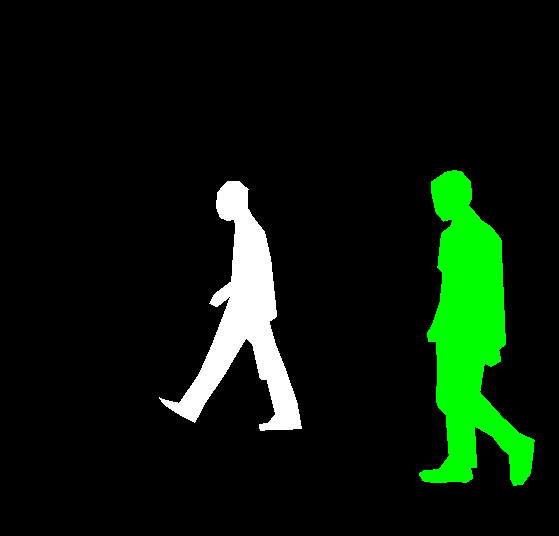

In [5]:
import numpy as np

mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
mask_np = np.array(mask)
print('mask_np:',mask_np.shape)
# png格式 通过索引值获取调色板上的像素值 
mask = mask.convert('P')
# 获取mask调色板
mask_palette = mask.getpalette()
# 获取png中每个像素点上的索引，通过getpixel
pixls = []
# for i in range(mask.width):
#     for j in range(mask.height):
#         pixls.append(mask.getpixel((i,j)))
[pixls.append(mask.getpixel((i,j))) for i in range(mask.width) for j in range(mask.height)]         
# 原始调色板为[0,0,0,1,1,1,2,2,2,3,3,3...,255,255,255],而索引为 0,1,2 索引后的像素值都十分接近黑色，不好分辨不同类别区域
# print(pixls)
# 查看索引的值有几种，即有几个类别
np.unique(pixls)
# 自定义调色板
mask.putpalette([
    0,0,0,
    255,255,255,
    0,255,0
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [6]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # 将img和对应的mask文件顺序相对齐
        self.imgs = list(sorted(os.listdir(os.path.join(root,'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root,'PedMasks'))))
        
    def __getitem__(self, idx):
        # 加载idx对应的图片和mask
        img_path = os.path.join(self.root,'PNGImages',self.imgs[idx])
        mask_path = os.path.join(self.root,'PedMasks',self.masks[idx])
        
        # 利用PIL.Image加载图片和mask
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        # mask有几种值即有几种instance
        mask = np.array(mask)# mask HxW
        obj_ids = np.unique(mask) # N
        # 第一个表示背景，去除之
        obj_ids = obj_ids[1:]
        
        # 每个channel表示一个instance的二值蒙板 Fasle/True
        masks = mask == obj_ids[:, None, None] # masks NxHxW
        
        # 获取目标的box坐标
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            boxes.append(self.getbbox(masks[i]))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # 只有1类所以label只有1,如果为多类则label为从1到N
        labels = torch.ones((num_objs,),dtype=torch.int64)
        masks = torch.as_tensor(masks,dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        iscrowd = torch.zeros((num_objs,),dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img,target)

        return img,target

    def __len__(self):
        return len(self.imgs)
        
        
    def getbbox(self, mask):
        rows = np.any(mask,axis = 1)
        cols = np.any(mask,axis = 0)
        # np.where 返回非0元素坐标以tuple形式返回，所以取tuple的[0]，再取第一个和最后一个
        rmin,rmax = np.where(rows)[0][[0,-1]]
        cmin,cmax = np.where(cols)[0][[0,-1]]
        return [cmin,rmin,cmax,rmax]

In [7]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

show the gound truth draw in raw image

In [8]:
import cv2
img = cv2.imread('PennFudanPed/PNGImages/FudanPed00001.png')
gt = cv2.rectangle(img,(159,181),(301,430),(0,255,0),3)
cv2.imwrite('gt_box.jpg',gt)

True

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining the model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

<!-- ![alt text](https://) -->

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

<!-- ![alt text](https://) -->

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 



## Test information and mask
```
>> mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
>> print('format of mask:',mask.format)
>> print('mode of mask:',mask.mode)
>> print('mask size:',mask.size)
>> print('mask info:',mask.info)

format of mask: PNG
mode of mask: L
mask size: (559, 536)
mask info: {}



>> label_instance = np.array([1,2])
>> label_instance = label_instance[:,None,None]
>> (mask_np==label_instance).shape

(2, 536, 559)

import numpy as np
img = np.array([[1,2,3,0,0],[0,0,0,1,3]])
rows = np.any(img,axis = 1)
np.where(rows)[0][[-1]]

```
